# Analysis file
First created by Vincent Belpaire.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale

locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

## Reading in the data

Remark all data was measured in mV!!! The data sampling took place with a sampling time of 10ms.

In [6]:
# These functions will be used to load in particular data files

def file(Bi, Aj, metal='', folder="data/"):
    filename = ''
    if metal == 'T':
        filename += 'T'
    filename += 'B' + str(Bi) + 'A' + str(Aj) + '.txt'
    return folder + filename

def read_data(file):
    with open(file, 'r') as infile:
        rawdata = infile.read()
        data = np.array([x.split(': ')[-1][:-3] for x in rawdata.split('\n')][1:-1]).astype(float) # exclude first and last data sample because they are not always complete
    infile.close()
    return data

## Data analysis

In [65]:
Ts = 0.1 # s (sampling periode) used delay was 100ms
Fs = 1/Ts # Hz (sampling frequency)

In [66]:
def plot_hall(ax,x,y,B,I):
    ax.plot(x,y)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
    ax.set_xlabel('tijd (s)')
    ax.set_ylabel('Spanning (mV)')
    ax.set_title(f'Magneetveldsterkte: {B} mT, Stroom: {I} A')

def plot_fft(ax,x,y,B,I):
    ax.plot(x,y)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
    ax.set_xlabel('frequentie (Hz)')
    ax.set_ylabel('Spanning (mV)')
    ax.set_title(f'Magneetveldsterkte: {B} mT, Stroom: {I} A')    

### 1. Koper

#### Omhse effecten

De databestanden met 'B0' in hun bestandsnaam werden gemaakt om de Ohmse effecten die eventueel aanwezig zouden zijn in het circuit te kunnen bestuderen. Deze informatie kan later gebruikt zijn om de data te "corrigeren" op deze effecten.

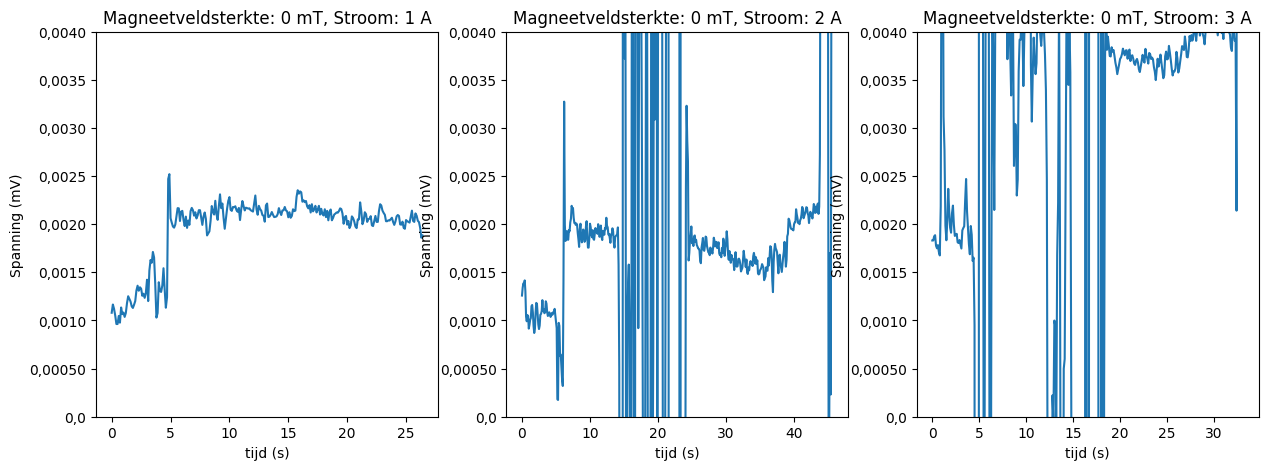

In [131]:
B = 0
A = [1,2,3]

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    plot_hall(ax[i],t,x,B,A[i])
    ax[i].set_ylim(0,0.004)



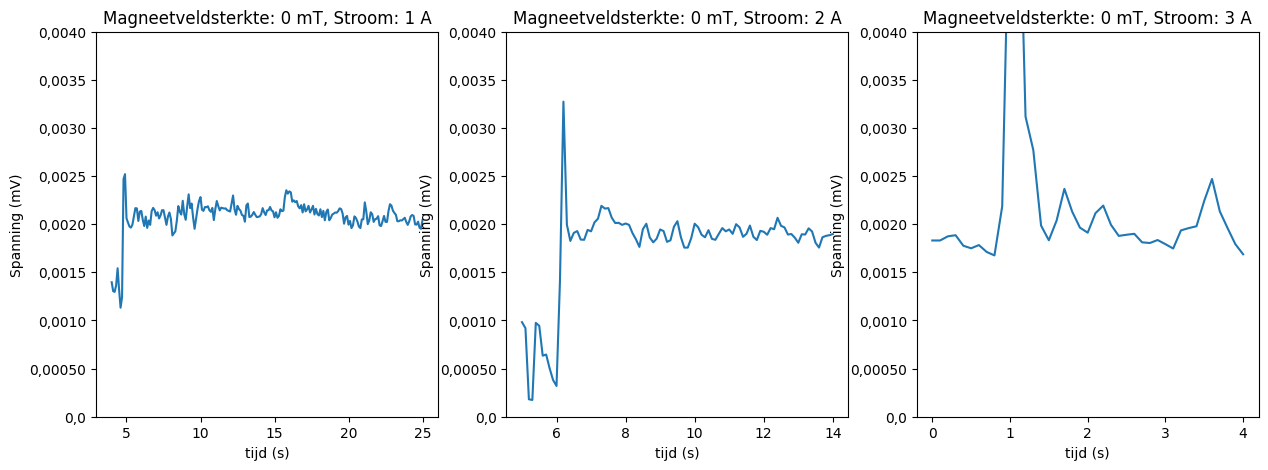

In [130]:
# aanpassen van de time window

fig, ax = plt.subplots(ncols=3,figsize=(15,5))
Tmin,Tmax = [4,5,0],[25,14,4]
#Tmin = [0,0,0]

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    tmin,tmax = Tmin[i],Tmax[i]
    plot_hall(ax[i],t[np.logical_and(tmin <= t, t <= tmax)],x[np.logical_and(tmin <= t, t <= tmax)],B,A[i])
    ax[i].set_ylim(0,0.004)

In de figuur voor B0A1 zien we duidelijk de sprong wanneer de stroom wordt aangezet. In de andere figuren is dit moeilijker te zien doordat er zeer grote ruispieken op te zien zijn. Wellicht heeft dit te maken door bewegingen van het circuit. Bij het collecteren van de data voor deze laaste twee figuren werd het magneet op het einde toegevoeg. Dit veroorzaakte wellicht veel beweging en dus ook ruis. 

Over ruis gesproken. We zien een oscillatie verschijnsle terug in de data. Met behulp van een Fourier analyse kan deze ruis misschien worden verwijderd.

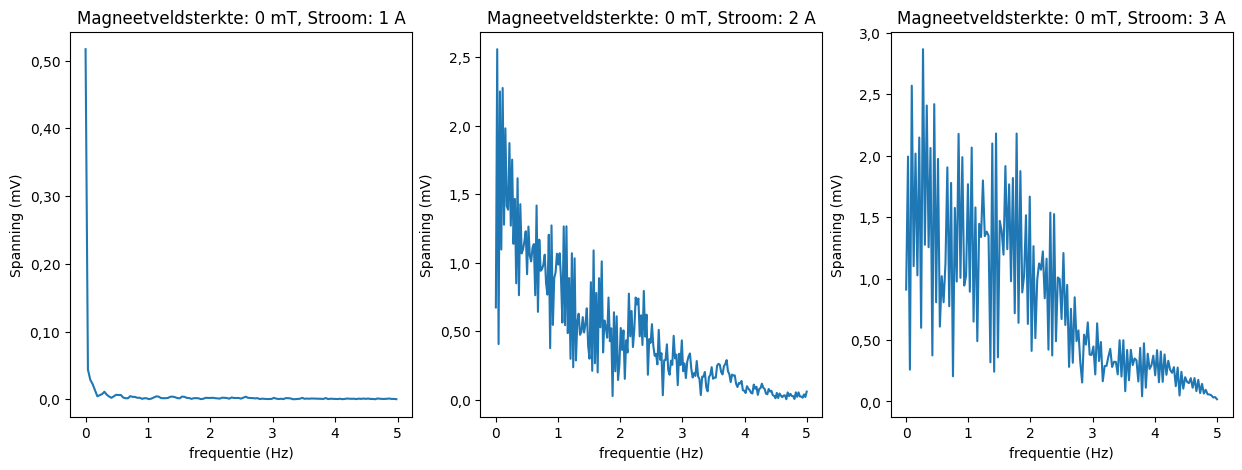

In [70]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    X = np.abs(np.fft.rfft(x))
    f = Fs*np.fft.rfftfreq(len(x))
    plot_fft(ax[i],f,X,B,A[i])

0.0021234310526315786 (0.0020689841025641025+0j)
0.0019227517105263154 (0.0018734503846153845+0j)
0.002668906842105263 (0.0026004733333333334+0j)


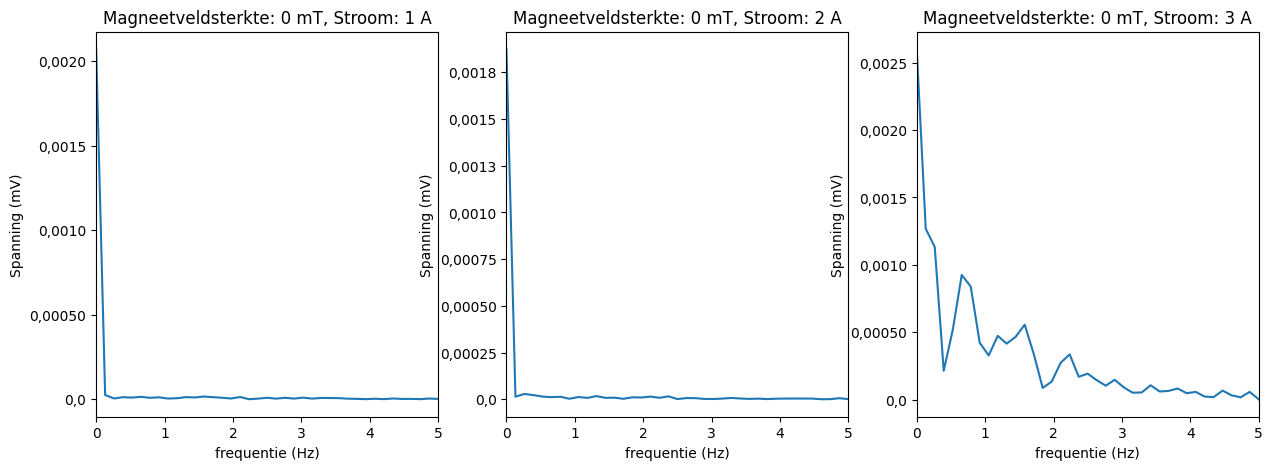

In [75]:
# aanpassen van de window

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    tmin,tmax = 6.5,14
    X = np.fft.rfft(x[np.logical_and(tmin <= t, t <= tmax)])
    f = Fs*np.fft.rfftfreq(len(x[np.logical_and(tmin <= t, t <= tmax)]))
    fmin,fmax = 0,max(f)
    AX = np.abs(X)/(2*len(X))
    plot_fft(ax[i],f[np.logical_and(fmin <= f, f <= fmax)],AX[np.logical_and(fmin <= f, f <= fmax)],B,A[i])
    ax[i].set_xlim(fmin,fmax)
    print(np.mean(x[np.logical_and(tmin <= t, t <= tmax)]),X[0]/(2*len(X)))

Het is nog niet direct duidelijk om uit dit een correctie term te vinden. Eventueel zou je de correctie uit kunnen voeren in het frequentie domein maar eenvoudiger zou het zijn om correcties toe te passen op berekende gemiddelde. Laten we nu alle data verzamelen behorden tot de stromen 1A,2A en 3A voor koper waarbij er geen magneet aanwezig was.

In [148]:
# Alles voor 0A

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(0 <= t, t <= 4)]
V = x
I = np.zeros(len(x))

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(0 <= t, t <= 4)]
V = np.concatenate((V,x))
I = np.concatenate((I,np.zeros(len(x))))

# Alles voor 1A

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(5 <= t, t <= np.max(t))]
V = np.concatenate((V,x))
I = np.concatenate((I,np.ones(len(x))))

# Alles voor 2A

x = read_data(file(0,A[1]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(7 <= t, t <= 14)]
V = np.concatenate((V,x))
I = np.concatenate((I,2*np.ones(len(x))))

# Alles voor 3A

x = read_data(file(0,A[2]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(2 <= t, t <= 4)]
V = np.concatenate((V,x))
I = np.concatenate((I,3*np.ones(len(x))))

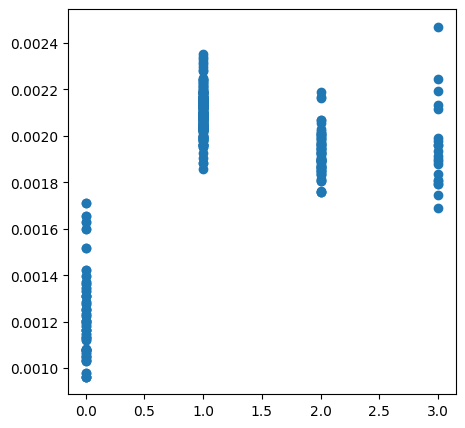

In [149]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(I,V)

#### Hall spanning

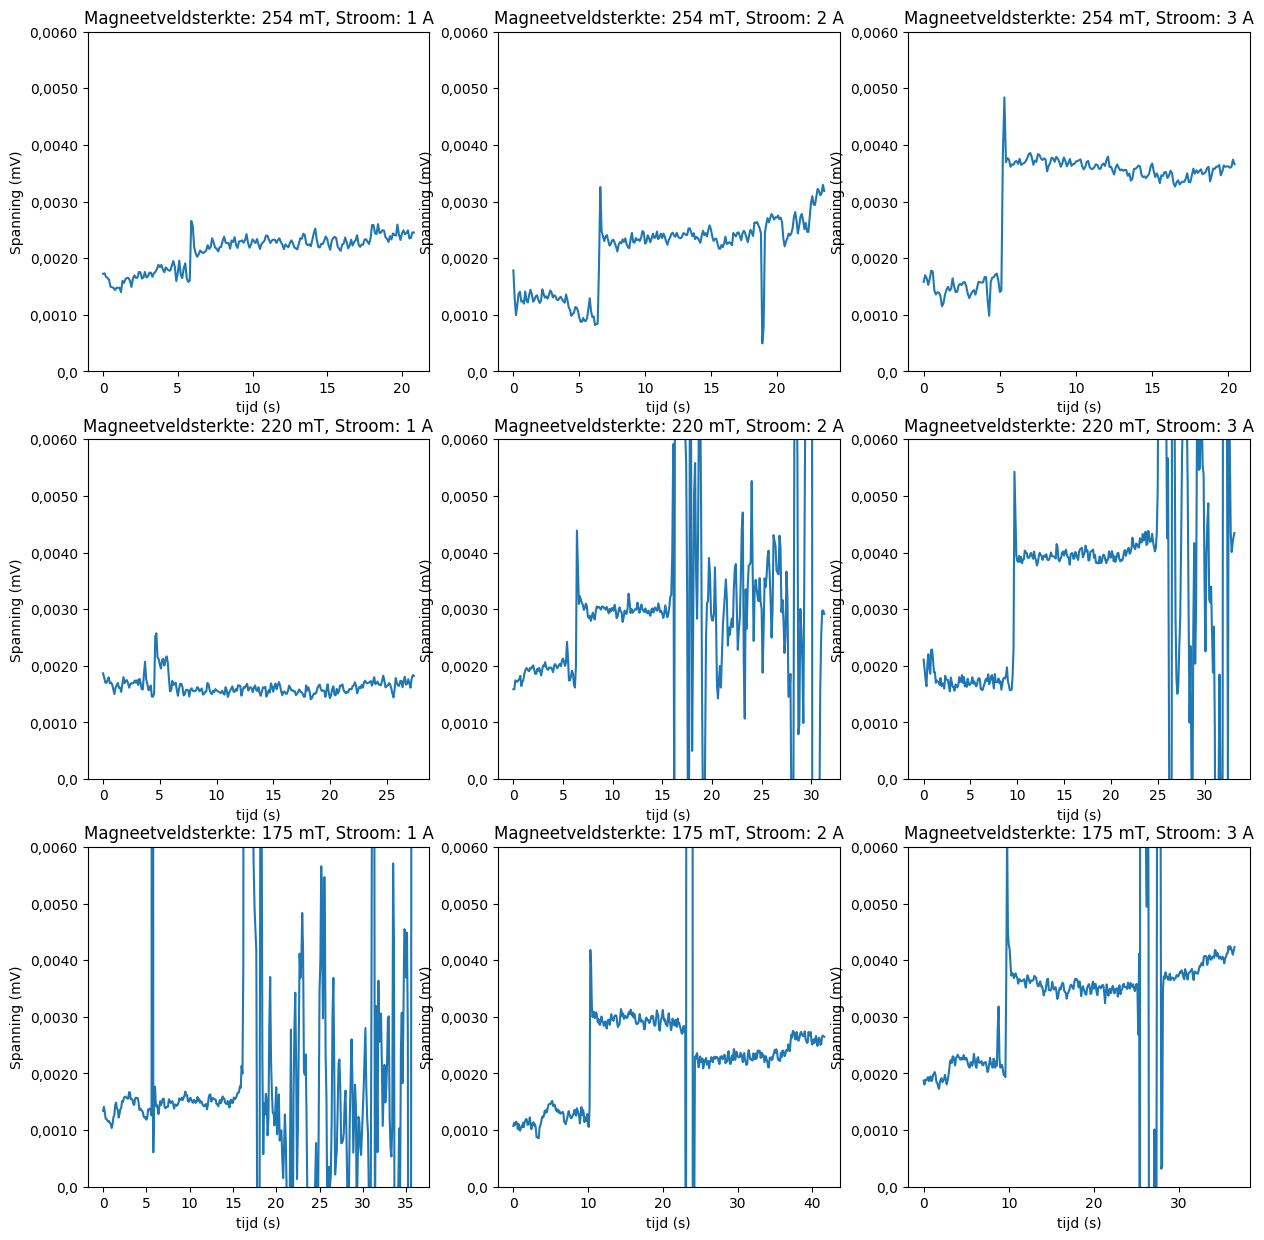

In [151]:
B = [254,220,175] # mT
A = np.array([1,2,3]) # A

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))

for i in range(3):
    for j in range(3):

        x = read_data(file(B[j],A[i]))
        N = len(x)
        t = Ts*np.arange(N)
        plot_hall(ax[j,i],t,x,B[j],A[i])
        ax[j,i].set_ylim(0,0.006)

Laten we om te starten enkel de drie metingen nemen met magneetveldsterkte van 254 mT. We houden ons tot het tijdsbereik tussen 600 en 1500 ms.

In [109]:
B = 254

UH = np.zeros(3)
UH_STD = np.zeros(3)

Errs = np.array([0.0021,0.0021,0.0026])

for i in range(3):
    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    UH[i] = np.mean(x[np.logical_and(6 < t, t < 15)]) - Errs[i] #np.mean(x[np.logical_and(0 < t, t < 5)])
    #UH_STD[i] = np.std(x[np.logical_and(600 < t, t < 1500)])

In [113]:
print(UH)
print(UH+Errs)
#print(UH_STD)

[0.00015956 0.00019661 0.00104411]
[0.00225956 0.00229661 0.00364411]


In [175]:
# parameters voor koper opstelling:

b = 2 # cm
h = 0.34 # mm
l2 = 10 # cm

e = 1.602176620*10**(-19)



In [182]:
# berekening voor 175 mT en 2A

x = read_data(file(175,2))
t = Ts*np.arange(len(x))

v = np.mean(x[np.logical_and(12 < t, t < 20)]) - np.mean(x[np.logical_and(40 < t, t < 45)])
n = l2/(b*h)*1/e*2*175/v*10**(-3)

print(n)

8.854789540222596e+22


Waarde van wikepedia: $8.47\times 10^{22}$ 1/$cm^3$

### 2. Tantaal

#### Hall spannig

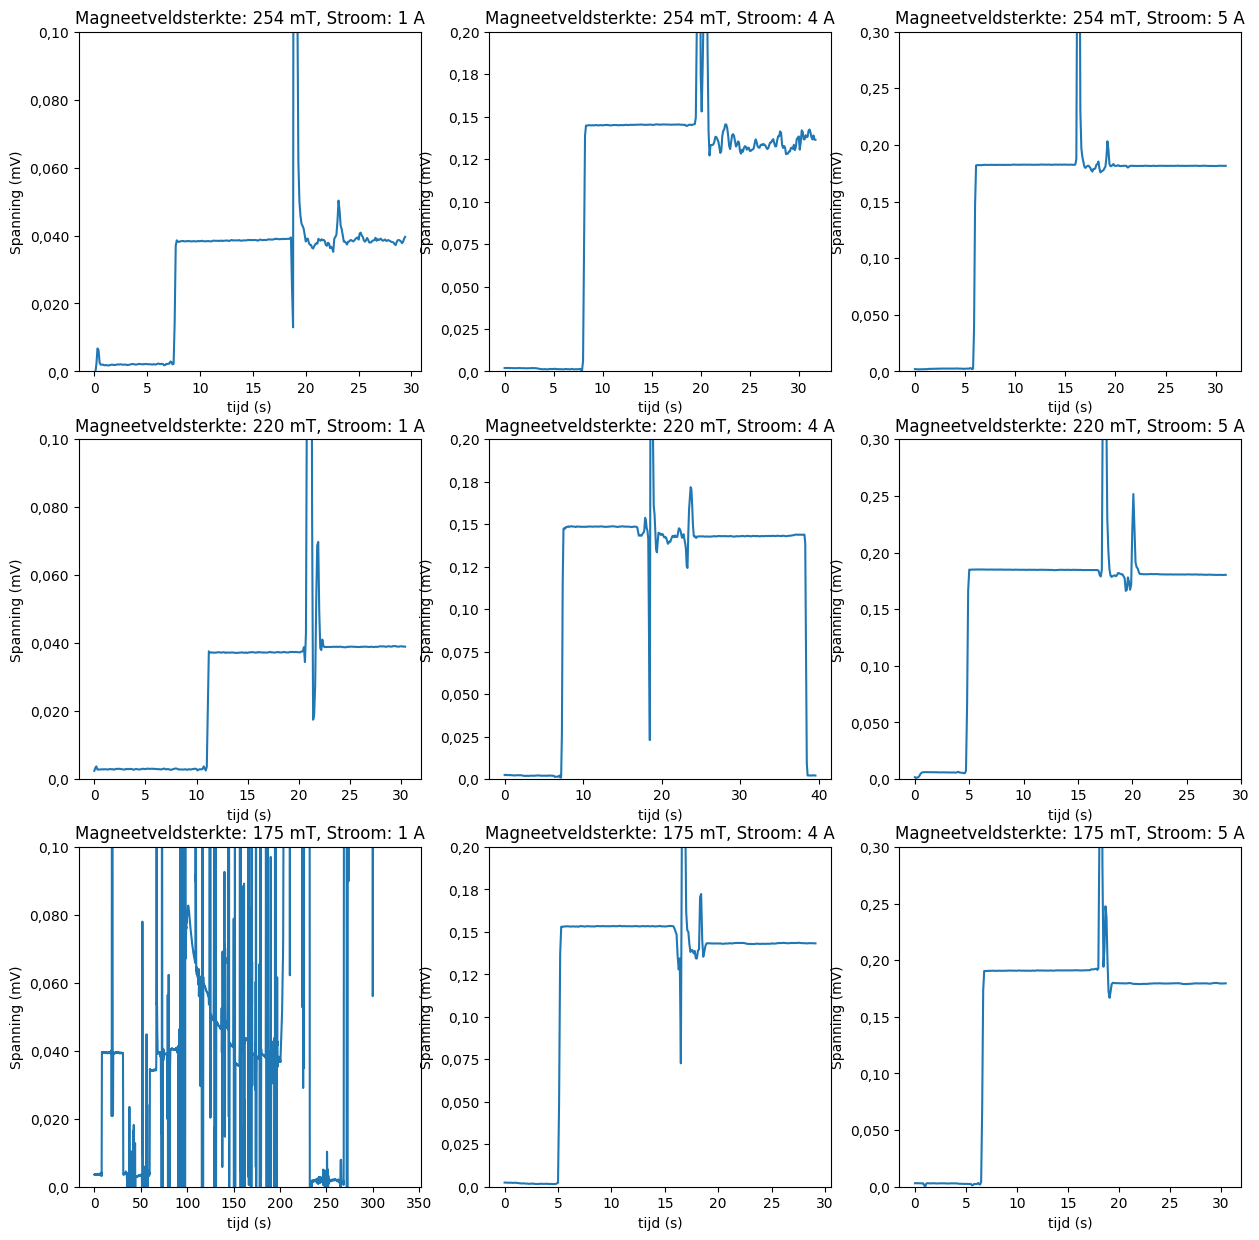

In [154]:
B = [254,220,175] # mT
A = np.array([1,4,5]) # A
Vlim = [0.1,0.2,0.3]

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))

for i in range(3):
    for j in range(3):

        x = read_data(file(B[j],A[i],metal='T'))
        N = len(x)
        t = Ts*np.arange(N)
        plot_hall(ax[j,i],t,x,B[j],A[i])
        ax[j,i].set_ylim(0,Vlim[i])

In [185]:
# parameters voor tantaal opstelling:

b = 2 # cm
h = 0.09 # mm
l2 = 10 # cm

e = 1.602176620*10**(-19)

# berekening voor 254 mT en 4A
I = 4
B = 254

x = read_data(file(B,I,metal='T'))
t = Ts*np.arange(len(x))

v = np.mean(x[np.logical_and(10 < t, t < 15)]) - np.mean(x[np.logical_and(23 < t, t < 30)])
n = l2/(b*h)*1/e*I*B/v*10**(-3)

print(n)

2.9441482560173985e+22


In [163]:
# estimae using Drude model
Navogadro = 6.02214076*10**(23) # mol^-1
Z = 5
rhom = 16.69 # g/cm^3 https://en.wikipedia.org/wiki/Tantalum
ma = 180.9479 # g/mol (molar mass) https://www.chemicalaid.com/tools/molarmass.php?formula=Ta&hl=en#:~:text=The%20molar%20mass%20and%20molecular,weight%20of%20Ta%20is%20180.948.

n = Navogadro*Z*rhom/ma
print(n)

2.777305768245998e+23


Beschouw de waarde voor "thallium": $1.05\times 10^{23}$ 1/$cm^3$ wat zeer dicht staat bij ons resultaat.